# Module 6 Lab 2 - Decision Tree to predict readmission

In this lab, we will attempt to predict readmissions using a decision tree, and compare the results to previous methods.

A decision tree will try to reduce entropy, or improve information gain, through an iterative process of splitting data in a tree structure before finally coming up with a model that can be used to predict the dependent variable.

Decision trees have the major benefit of being highly explainable, although a sufficiently deep tree will quickly become unusable except by a machine.  

If a problem can be solved efficiently with a decision tree, then it should be a preferred method investigated for applicability in the problem you are solving.  Besides the inherent explainable nature of the resulting model, a decision tree that is small enough can also be used without a computer, which can be beneficial in places where computer access is limited.  In the medical field, some countries without adequate infrastructure can benefit from non-computerized decision support.

Decision trees can handle categorical data mixed with continuous, but the categorical data must be one-hot-encoded.  If the data are ordinal, then the data can be encoded as an ordinal integer rather than one hot encoded.  The reason this is possible is because it is meaningful to apply less than and greater than to Ordinal categorical data.  Decision Trees make their splits using these operators.

In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

## Apply transformations to our data
These are the same transformations as applied to the logistic regression model.  See Lab 1 for more explanations.

In [3]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('../resources/diabetes_readmission.csv')
display(data.head())

y = data['readmitted']
X = data[['discharge', 'age', 'race', 'admission_type', 'specialty', 'time_in_hospital', 'diag_1', 'A1Cresult', 'change']].copy()

scaler = StandardScaler()
X['time_in_hospital'] = scaler.fit_transform(X[['time_in_hospital']])

# create dummy variables
X = pd.concat([X, pd.get_dummies(X['age'], prefix = 'age', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['race'], prefix = 'race', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['admission_type'], prefix = 'admission_type', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['specialty'], prefix = 'specialty', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['diag_1'], prefix = 'diag_1', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['A1Cresult'], prefix = 'A1Cresult', drop_first=True)], axis=1)

# drop originals
X = X.drop(['age', 'race', 'admission_type', 'specialty', 'diag_1', 'A1Cresult'], axis=1)

# balance the classes
display(y.value_counts())

X_oversampled, y_oversampled = resample(X[y == 1], y[y == 1], replace=True, n_samples=X[y == 0].shape[0], random_state=42)

X = pd.DataFrame(np.vstack((X[y == 0], X_oversampled)), columns=X.columns)
y = np.hstack((y[y == 0], y_oversampled))

display(pd.Series(y).value_counts())

,readmitted,discharge,age,race,admission_type,specialty,time_in_hospital,diag_1,A1Cresult,change
0,1,0,0,1,1,0,8,8,0,1
1,0,0,0,1,1,4,2,8,0,0
2,0,1,2,1,1,2,4,8,2,0
3,0,0,2,1,1,2,3,8,3,1
4,0,0,0,0,1,2,5,8,0,0


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0    60145
1     5813
Name: readmitted, dtype: int64

1    60145
0    60145
dtype: int64

## Train the Decision Tree
Here we are building the model using [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# train/test split, specify the seed for reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


clf = DecisionTreeClassifier(random_state=42)
model = clf.fit(X_train, y_train)



## Visualize and compare the results

accuracy 0.6582779121322048
tree depth 21


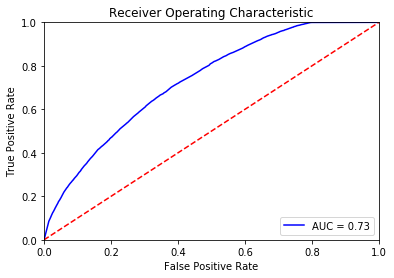

confusion matrix:
[[12684  7265]
 [ 6300 13447]]

classification report:
              precision    recall  f1-score   support

           0       0.67      0.64      0.65     19949
           1       0.65      0.68      0.66     19747

   micro avg       0.66      0.66      0.66     39696
   macro avg       0.66      0.66      0.66     39696
weighted avg       0.66      0.66      0.66     39696



In [5]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

print('accuracy', model.score(X_test, y_test))

print('tree depth', model.tree_.max_depth)

probs = model.predict_proba(X_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred = model.predict(X_test)

cmatrix = confusion_matrix(y_test, y_pred)
print('confusion matrix:')
print(cmatrix)
print('\nclassification report:')
print(classification_report(y_test, y_pred))

## Results
Both the ROC and Accuracy are higher than logistic regression.  

The precision (the proportion of true positives out of all identified positives) is also higher for both cases than the logistic regression.

In this case, we might prefer the decision tree over the regression becuase it gives better performance, and it is still explainable.

